<a href="https://colab.research.google.com/github/SeanSUN2/Temp/blob/main/RAG_using_Llama3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install dependecies

In [ ]:
!pip install -q datasets sentence-transformers faiss-cpu accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00


# login with your token

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# embed dataset

this is a slow procedure so you might consider saving your results

In [ ]:
from datasets import load_dataset

dataset = load_dataset("not-lain/wikipedia")

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 3000
    })
})

In [ ]:
from sentence_transformers import SentenceTransformer
ST = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/113k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
# embed the dataset
def embed(batch):
  # or you can combine multiple columns here, for example the title and the text
  information = batch["text"]
  return {"embeddings" : ST.encode(information)}
dataset = dataset.map(embed,batched=True,batch_size=16)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
dataset.push_to_hub("not-lain/wikipedia", revision="embedded")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/374 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/not-lain/wikipedia/commit/5ef41506022e917cf036b507930134426b86fdfc', commit_message='Upload dataset', commit_description='', oid='5ef41506022e917cf036b507930134426b86fdfc', pr_url=None, pr_revision=None, pr_num=None)

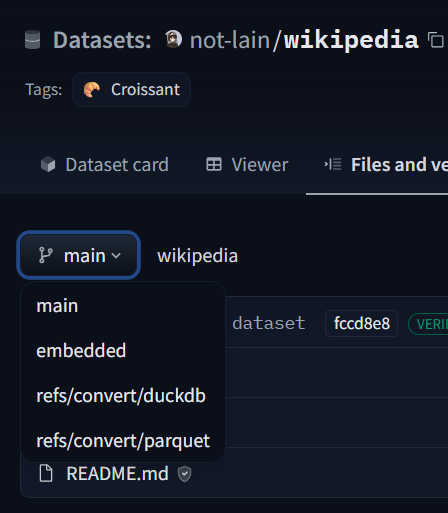

In [ ]:
from datasets import load_dataset

dataset = load_dataset("not-lain/wikipedia",revision = "embedded")

In [ ]:
data = dataset["train"]
data = data.add_faiss_index("embeddings") # column name that has the embeddings of the dataset

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def search(query: str, k: int = 3 ):
    """a function that embeds a new query and returns the most probable results"""
    embedded_query = ST.encode(query) # embed new query
    scores, retrieved_examples = data.get_nearest_examples( # retrieve results
        "embeddings", embedded_query, # compare our new embedded query with the dataset embeddings
        k=k # get only top k results
    )
    return scores, retrieved_examples

In [ ]:
scores , result = search("anarchy", 4 ) # search for word anarchy and get the best 4 matching values from the dataset

In [ ]:
# the lower the better
scores

array([152.02185, 201.72916, 251.14886, 259.323  ], dtype=float32)

In [ ]:
result['title']

['Anarchism', 'Anarcho-capitalism', 'Community', 'Capitalism']

In [ ]:
print(result["text"][0])

Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).

Humans have lived in societies without formal hierarchies long before the establishment of states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose. Although traces of anarchist ideas are found all throughout history, modern anarchism emerged from the Enlightenment. During the latter half of the 19th and the first decades of the 20th century, the anarchist movement f

# chatbot on top of the retrieved results

In [ ]:
!pip install -q datasets sentence-transformers faiss-cpu accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 28.4 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
ST = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("not-lain/wikipedia",revision = "embedded")

In [ ]:
data = dataset["train"]
data = data.add_faiss_index("embeddings") # column name that has the embeddings of the dataset

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def search(query: str, k: int = 3 ):
    """a function that embeds a new query and returns the most probable results"""
    embedded_query = ST.encode(query) # embed new query
    scores, retrieved_examples = data.get_nearest_examples( # retrieve results
        "embeddings", embedded_query, # compare our new embedded query with the dataset embeddings
        k=k # get only top k results
    )
    return scores, retrieved_examples

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=bnb_config
)
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
SYS_PROMPT = """You are an assistant for answering questions.
You are given the extracted parts of a long document and a question. Provide a conversational answer.
If you don't know the answer, just say "I do not know." Don't make up an answer."""

In [ ]:
def format_prompt(prompt,retrieved_documents,k):
  """using the retrieved documents we will prompt the model to generate our responses"""
  PROMPT = f"Question:{prompt}\nContext:"
  for idx in range(k) :
    PROMPT+= f"{retrieved_documents['text'][idx]}\n"
  return PROMPT

def generate(formatted_prompt):
  formatted_prompt = formatted_prompt[:2000] # to avoid GPU OOM
  messages = [{"role":"system","content":SYS_PROMPT},{"role":"user","content":formatted_prompt}]
  # tell the model to generate
  input_ids = tokenizer.apply_chat_template(
      messages,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(model.device)
  outputs = model.generate(
      input_ids,
      max_new_tokens=1024,
      eos_token_id=terminators,
      do_sample=True,
      temperature=0.6,
      top_p=0.9,
  )
  response = outputs[0][input_ids.shape[-1]:]
  return tokenizer.decode(response, skip_special_tokens=True)


In [ ]:
def rag_chatbot(prompt:str,k:int=2):
  scores , retrieved_documents = search(prompt, k)
  formatted_prompt = format_prompt(prompt,retrieved_documents,k)
  return generate(formatted_prompt)

In [ ]:
rag_chatbot("what's anarchy ?", k = 2)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


So, anarchism is a political philosophy that questions the need for authority and hierarchy, and seeks to create a society without a state or government. It's often associated with the idea of voluntary, free associations and the abolition of institutions that maintain coercion and hierarchy. Anarchists believe that people can live together without the need for a central authority figure, and that individuals should be free to make their own choices and decisions.

In essence, anarchism is about challenging the status quo and creating a more equal and just society. It's a philosophy that has been around for a long time, with roots in the Enlightenment and a significant presence in workers' struggles for emancipation throughout history. Today, anarchism continues to influence anti-capitalist, anti-war, and anti-globalization movements, and is often seen as a libertarian wing of the socialist movement.

It's worth noting that anarchism is not just about chaos and disorder, as some people